In [1]:
pip install pandas numpy scikit-learn matplotlib yfinance


Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [10]:
# Download Apple stock data
data = yf.download("AAPL", start="2015-01-01", end="2023-01-01")

# Calculate moving averages and relative price change
data['SMA_10'] = data['Close'].rolling(window=10).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['Price_Change'] = data['Close'].pct_change()

# set target as next days close
data['Target'] = data['Close'].shift(-1)

# Drop rows with missing values
data.dropna(inplace=True)

#print(data.head())

[*********************100%***********************]  1 of 1 completed


In [11]:
#scale data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = data[['SMA_10', 'SMA_50', 'Price_Change']]
X_scaled = scaler_X.fit_transform(X)

y = data['Target']
y_scaled = scaler_y.fit_transform(y.to_frame())


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

Training samples: 1571, Testing samples: 393


<h1> GridSearch setup </h1>

In [12]:
# Define the different hyperparameters for a support vector machine
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],   #the method for transforming the data into anthor dimension so the SVM can find a hyperplane 
    'C': [0.1, 1, 10, 100],        #paramter for penalizing misclassifications - effects under or over fitting
    'gamma': ['scale', 'auto'],            #controlls weight of each point, lower gamma - smoother decision boundary, more generalised
    'degree': [2, 3, 4, 5]                 #degee of polynomial
}

In [13]:
#training
svr = SVR()

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=svr,
    param_grid=param_grid,
    cv=3,                       # cross-validation
    scoring='neg_mean_absolute_error',         # Use mse as scoring
    verbose=100,
    n_jobs=-1                   # Use all available cores
)

# Perform grid search on training data
grid_search.fit(X_train, y_train)

results_df = pd.DataFrame(grid_search.cv_results_)


Fitting 3 folds for each of 96 candidates, totalling 288 fits


C:\Users\kenan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
results_df = pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_score', ascending=False)
for i, row in results_df.iterrows():
    print(f"Rank {row['rank_test_score']}:")
    print(f"Parameters: {row['params']}")
    print(f"Mean Test Score: {row['mean_test_score']:.4f}")
    print(f"Std Dev of Test Score: {row['std_test_score']:.4f}")
    print("-" * 30)

Rank 1:
Parameters: {'C': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Mean Test Score: -0.0409
Std Dev of Test Score: 0.0021
------------------------------
Rank 1:
Parameters: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Mean Test Score: -0.0409
Std Dev of Test Score: 0.0021
------------------------------
Rank 1:
Parameters: {'C': 1, 'degree': 2, 'gamma': 'auto', 'kernel': 'linear'}
Mean Test Score: -0.0409
Std Dev of Test Score: 0.0021
------------------------------
Rank 1:
Parameters: {'C': 1, 'degree': 5, 'gamma': 'auto', 'kernel': 'linear'}
Mean Test Score: -0.0409
Std Dev of Test Score: 0.0021
------------------------------
Rank 1:
Parameters: {'C': 1, 'degree': 5, 'gamma': 'scale', 'kernel': 'linear'}
Mean Test Score: -0.0409
Std Dev of Test Score: 0.0021
------------------------------
Rank 1:
Parameters: {'C': 1, 'degree': 4, 'gamma': 'auto', 'kernel': 'linear'}
Mean Test Score: -0.0409
Std Dev of Test Score: 0.0021
------------------------------
Rank 1:

Final Model MAE: 0.04366868698002005
Final Model RMSE: 0.0637298676906731


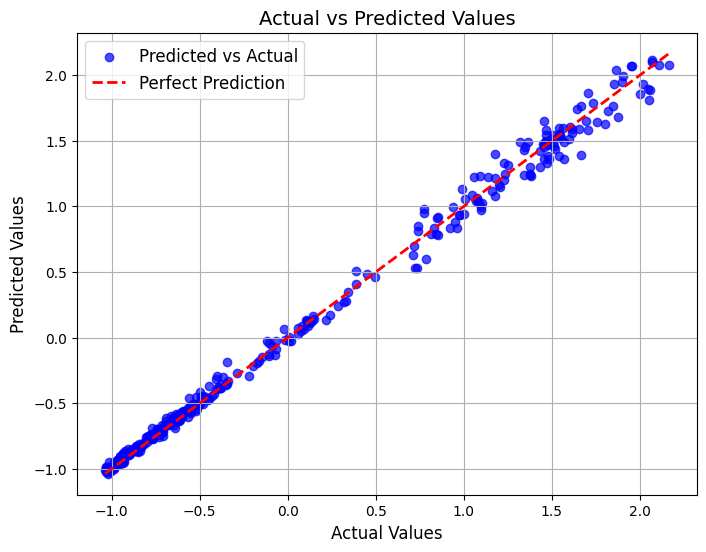

In [15]:
# use best model to predict
final_model = grid_search.best_estimator_

# Predict on test data
final_predictions = final_model.predict(X_test)

# Evaluate the final model
mae = mean_absolute_error(y_test, final_predictions)
mse = mean_squared_error(y_test, final_predictions)
rmse = np.sqrt(mse)

print(f"Final Model MAE: {mae}")
print(f"Final Model RMSE: {rmse}")

# Visualize Predictions vs. Actual Outcomes
plt.figure(figsize=(8, 6))
plt.scatter(y_test, final_predictions, alpha=0.7, color='b', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')  # Diagonal line
plt.title('Actual vs Predicted Values', fontsize=14)
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

[*********************100%***********************]  1 of 1 completed

Final Model MAE: 0.4029099771259549
Final Model RMSE: 0.5076350491363062


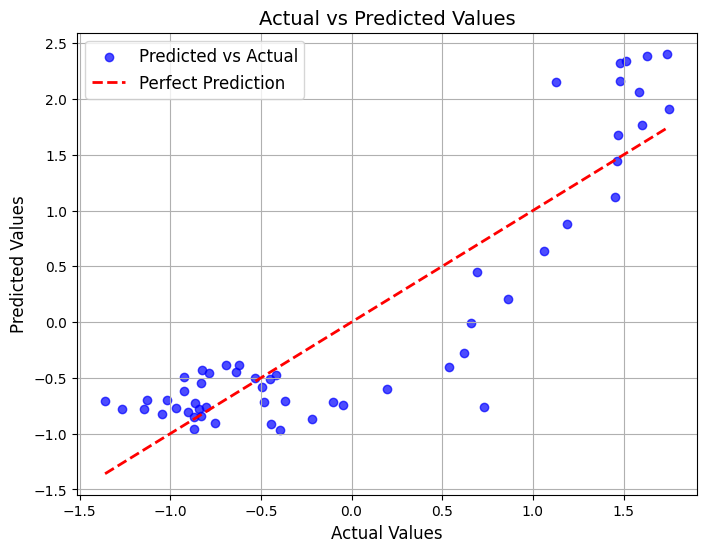

In [20]:
# trying to predict more recent ones
stock = yf.Ticker('AAPL')
data_to_predict = yf.download("AAPL", start="2024-01-01", end="2024-06-01")
data_to_predict['SMA_10'] = data_to_predict['Close'].rolling(window=10).mean()
data_to_predict['SMA_50'] = data_to_predict['Close'].rolling(window=50).mean()
data_to_predict['Price_Change'] = data_to_predict['Close'].pct_change()
data_to_predict['Target'] = data_to_predict['Close'].shift(-1)
data_to_predict.dropna(inplace=True)

X = data_to_predict[['SMA_10', 'SMA_50', 'Price_Change']]
Y = data_to_predict['Target']

X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_y.fit_transform(Y.to_frame())

final_predictions = final_model.predict(X_scaled)

mae = mean_absolute_error(Y_scaled, final_predictions)
mse = mean_squared_error(Y_scaled, final_predictions)
rmse = np.sqrt(mse)

print(f"Final Model MAE: {mae}")
print(f"Final Model RMSE: {rmse}")

# Visualize Predictions vs. Actual Outcomes
plt.figure(figsize=(8, 6))
plt.scatter(Y_scaled, final_predictions, alpha=0.7, color='b', label='Predicted vs Actual')
plt.plot([Y_scaled.min(), Y_scaled.max()], [Y_scaled.min(), Y_scaled.max()], 'r--', lw=2, label='Perfect Prediction')  # Diagonal line
plt.title('Actual vs Predicted Values', fontsize=14)
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()